In [1]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_DIR = '/Volumes/TOSHIBA_EXT/Promotion/data/A1/data2/'
DATA_VERSION = 'oct22'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
RESULTS_DIR = '/Volumes/TOSHIBA_EXT/Promotion/data/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [2]:
import os 
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ann

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

import datetime

import upsetplot

#plt.rcParams['figure.dpi'] = 300

sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 8.3.2
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
h5py                3.7.0
hypergeom_ufunc     NA
igraph              0.9.11
ipykernel           6.17.1
ipython_genutils    0.2.0
ipywidgets          8.0.6
jedi                0.18.1
joblib              1.2.0
jupyter_server      1.23.2
kiwisolver          1.4.4
leidenalg           0.8.10
llvmlite            0.36.0
matplotlib          3.5.3
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.53.1
numpy               1.20.3
packaging           21.3
pandas              1.5.1
parso  

# Get LR pairs
We calculate LR pairs with cellphonedb between celltypes for each bone in 1. in Naive, 2. in MCAO., 3. Sham
1. Filter out celltypes according cell counts (copy the according celltype list into the scripts of 2.)
2. Run cellphonedb (explanation below on how to use the seperate scripts)
3. Plots

#### Filter celltypes according cell counts
To have a fairer comparison we only consider celltypes that have more than `min_count=10` cells in each bone in both Naive and MCAO. 

In [ ]:
ct_selections = {
    'level1':['B cell', 'dendritic cell', 'erythroid cell', 'erythroid precursor', 'monocyte', 
              'neutrophil', 'NK cell', 'NK-T cell', 'progenitors', 'T cell'],
    'level2_min10':['Cd8 T cell', 'erythroblast', 'erythrocyte', 'erythroid cell', 
                    'erythroid progenitor', 'immature neutrophil', 'mature B cell', 
                    'mature neutrophil', 'monocyte progenitor', 'monocyte-primed GMP', 
                    'neutrophil-primed GMP', 'NK cell', 'NK-T cell', 'plasmacytoid DC', 
                    'pre neutrophil', 'pro neutrophil'],
    'level2_min5':['basophil', 'Cd4 T cell', 'Cd8 T cell', 'common myeloid progenitor', 'erythroblast', 
                   'erythrocyte', 'erythroid cell', 'erythroid progenitor', 'granulocyte-monocyte progenitor', 
                   'immature B cell', 'immature neutrophil', 'mature B cell', 'mature neutrophil', 
                   'monocyte progenitor', 'monocyte-primed GMP', 'neutrophil-primed GMP', 'NK cell', 'NK-T cell', 
                   'non-classical monocyte', 'plasmacytoid DC', 'pre neutrophil', 'pro neutrophil'],
}

### Run scripts
- To produce the cellphonedb analysis outputs run `./scripts/script_cpdb.sh` with according arguments, e.g. summarised by running `bash ./scripts/script_cpdb_run.sh`. 
- For those scripts two minimalistic conda environments are used: 'a1_scanpy' to run `./scripts/script_cpdb_data.py` which creates txt files data tables, and 'a1_cpdb' to run cellphonedb commands. 
- Some parameters that might be interesting:
    - in `./scripts/script_cpdb.sh`: `DATA_DIR` and `RESULTS_DIR`. We expect `f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad'` to be in `DATA_DIR`. `RESULTS_DIR` defines the folder where the results are saved.
    - in `./scripts/script_cpdb_data.py` we set `CELLTYPES` as the list of the above selected celltypes. Only interactions between those celltypes are considered.

### Plots
With the results of the scripts we then create plots.

#### Summary upset plots
Measure the number of interactions that are specifically shared between bones of any subset of all bones.

**Update (30.11.21): We add two things to make the selection stricter:**
1. `max_pval = 10**(-10)` instead of `0.05`
2. Add a min pval difference of `0.95` between the groups.

# Ligand Receptor Interaction Plots 

In [3]:
SEED = 0 # set seed (refers to sampling in cellphonedb computations, seed 0 uses geometric sketching, other seeds were for checking robustness of the results)

In [4]:
ct_selections = {
    'level1':['B cell', 'dendritic cell', 'erythroid cell', 'erythroid precursor', 'monocyte', 
              'neutrophil', 'NK cell', 'NK-T cell', 'progenitors', 'T cell'],
    'level2_min10':['Cd8 T cell', 'erythroblast', 'erythrocyte', 'erythroid cell', 
                    'erythroid progenitor', 'immature neutrophil', 'mature B cell', 
                    'mature neutrophil', 'monocyte progenitor', 'monocyte-primed GMP', 
                    'neutrophil-primed GMP', 'NK cell', 'NK-T cell', 'plasmacytoid DC', 
                    'pre neutrophil', 'pro neutrophil'],
    'level2_min5':['basophil', 'Cd4 T cell', 'Cd8 T cell', 'common myeloid progenitor', 'erythroblast', 
                   'erythrocyte', 'erythroid cell', 'erythroid progenitor', 'granulocyte-monocyte progenitor', 
                   'immature B cell', 'immature neutrophil', 'mature B cell', 'mature neutrophil', 
                   'monocyte progenitor', 'monocyte-primed GMP', 'neutrophil-primed GMP', 'NK cell', 'NK-T cell', 
                   'non-classical monocyte', 'plasmacytoid DC', 'pre neutrophil', 'pro neutrophil'],
}

In [5]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

In [6]:
cond_to_color = {
    cond:color for cond, color in zip(adata.obs["condition"].cat.categories,adata.uns["condition_colors"])
}

In [7]:
def unique_interactions_df(#bones,
                           condition,celltypes,ct_selections_key="level1",seed=0,
                           any_bone=False,max_pval=10**(-10),min_pval_diff=0.95,results_dir=RESULTS_DIR):
    """Get ligand-recptor pairs that are only present in `bones`
    
    A similar dataframe as in the upset_df is created and from that we extract the LR-pairs of interest.
    
    Arguments
    ---------
    #bones: list of strs
    condition: str
    celltypes: list of strs
    any_bone: bool
        If True the returned table contains interactions that are present in at least one of `bones`. If False
        the interactions are only present in all `bones` and not in others.
    
    Returns
    -------
    two pd.DataFrames:
        1. with boolean values for bone combinations
        2. with pvals instead of bool values (1. was created from 2. based on the given threshold)
    
    """
    lr_infos = pd.DataFrame(columns=['id_cp_interaction','interacting_pair','gene_a','gene_b']).set_index('id_cp_interaction')
    series = []
    series_p = []
    all_bones = ['Skull', 'Vertebra', 'Humerus', 'Femur', 'Pelvis']#['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus', 'Scapula']
    #all_bones = ['Skull', 'Vertebra', 'Scapula', 'Humerus', 'Femur', 'Pelvis']#['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus', 'Scapula']
    for r in all_bones:
        #path = results_dir+f'cellphone_out/{condition}_{r}/pvalues.txt'
        #path = results_dir + f'cellphone_out/{ct_selections_key}_{condition}_{r}/pvalues.txt'
        path = results_dir + f'cellphone_out/{ct_selections_key}_{condition}_{r}_seed{seed}/pvalues.txt'
        df = pd.read_csv(path,sep='\t')
        cell_pairs = df.columns[11:]
        cell_pairs = [p for p in cell_pairs if ((p.rsplit("|")[0] in celltypes) and (p.rsplit("|")[1] in celltypes))]
        df.set_index('id_cp_interaction', inplace=True)
        interactions = [v for v in df.index.values if not v in lr_infos.index]
        lr_infos = pd.concat([lr_infos,df.loc[interactions,['interacting_pair','gene_a','gene_b']]])
        #lr_infos.loc[interactions,['interacting_pair','gene_a','gene_b']] = df.loc[interactions,['interacting_pair','gene_a','gene_b']]
        df = df[cell_pairs]
        df_p = df.copy()
        df = df < max_pval
        df = df.stack() 
        df_p = df_p.stack()
        df.name = r
        df_p.name = r
        series.append(df)
        series_p.append(df_p)
    df = pd.concat(series,axis=1)
    df_p = pd.concat(series_p,axis=1)
    #df_p[df.isnull()] = 1
    df[df.isnull()] = False
    df_p = df_p[df.any(axis=1)]
    df = df[df.any(axis=1)]  
    df = df.astype(bool)
    
    # Filter with min p_value threshold (except for interactions of all bones)
    # get maximum of significant pvals (which should be < 10**-10)
    max_sign = np.max(df[all_bones].values * df_p[all_bones].values,axis=1)
    # get minimum of insignificant pvals
    tmp = df_p.copy()
    tmp.values[df.values] += 1
    min_insign = np.min(tmp.values,axis=1)
    filt = ((min_insign - max_sign) > min_pval_diff)
    filt_all_bones = df.all(axis=1) # actually this we wouldn't need that... `filt` doesn't filter those out
    df_p = df_p.loc[filt | filt_all_bones]
    df = df.loc[filt | filt_all_bones]
    
    #if any_bone:
    #    filt = df[bones].any(axis=1)
    #else:
    #    filt = df[bones].all(axis=1) & ~df[[b for b in all_bones if not b in bones]].any(axis=1)
    #df = df.loc[filt]
    #df_p = df_p.loc[filt]
    
    idxs = df.index.get_level_values(0)
    for col in ['interacting_pair','gene_a','gene_b']:
        df[col] = lr_infos.loc[idxs,col].values
        df_p[col] = lr_infos.loc[idxs,col].values
    
    df = df.rename(columns={"Skull":"Calvaria"})
    df_p = df_p.rename(columns={"Skull":"Calvaria"})
    
    return df, df_p



# Upset Plots

It's really hard to find a good solution that merges the three conditions easily. Instead of a full solution we'll create 4 plots and merge them manually. Sth I really don't want to do... but otherwise it will take even longer.

The 4 plots
- 1-3: for each condition the upset bars in the color of the condition (order needs to be fixed by one condition!)
- 4: The lower part of the upset plot in black. The bars on the left should show number of unique interactions per bone. For this you need to merge all three dfs in such a way that redundant interactions (i.e. those that occur in more than one condition) is reduced to one condition.


In [8]:
bones = ["Calvaria","Vertebra","Humerus","Femur","Pelvis"]

In [9]:
dfs = {}

for cond in ["Naive", "Sham", "MCAO"]:
    df, df_p = unique_interactions_df(
        cond,ct_selections['level1'],ct_selections_key="level1",any_bone=False,seed=SEED,
        max_pval=10**(-10),min_pval_diff=0.95,results_dir=RESULTS_DIR
    )
    dfs[cond] = df

/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/887345696.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_.loc[comb, "value_counts"] = vcount


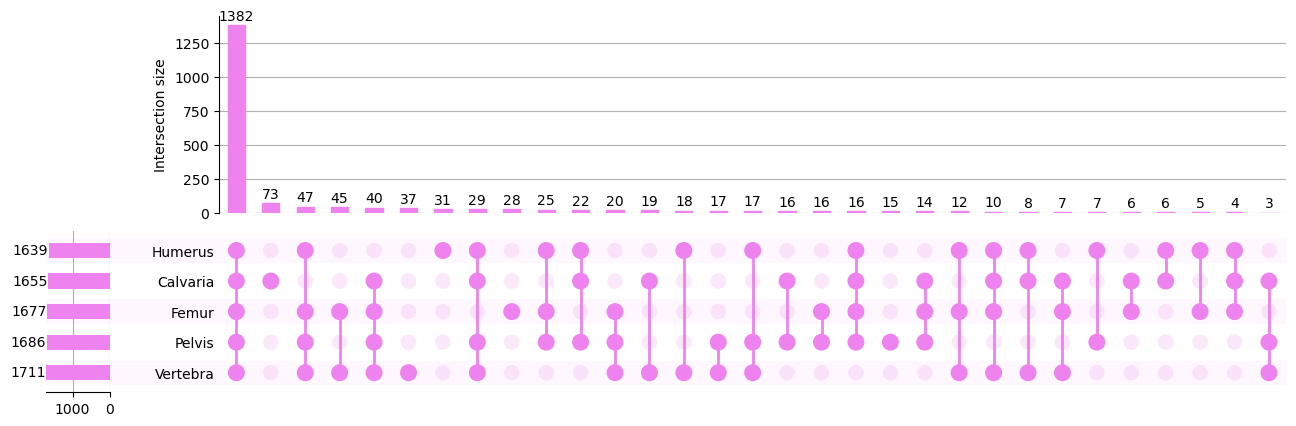

In [10]:
# example
df_ = df.set_index(bones)#.index.value_counts()

df_["value_counts"] = 0
for comb, vcount in df_.index.value_counts().items():
    df_.loc[comb, "value_counts"] = vcount
df_ = df_.sort_values("value_counts", ascending=False)

upsetplot.UpSet(df_, sort_by='input', show_counts=True, facecolor="violet")

There are no functionalities that easily set the same shown combinations for the three conditions (the problem is that each condition has different combinations that have 0 LR pairs) - to solve that issue we add pseudo columns that we color differently. (Update: at the end only the top 15 combinations from Naive were shown which occur at least once in all conditions, the pseudo interactions are still in the code but doesn't change anything). 

In [11]:
# df for lower upset part (and ordering)
df = pd.concat([dfs["Naive"], dfs["Sham"], dfs["MCAO"]]).reset_index().drop_duplicates(keep='last')
df = df.set_index(bones)


In [12]:
# Initialize dataframe that contains the info for each condition which pseudo rows are needed
combs = [comb for comb in df.index.value_counts().index]
df_pseudo = pd.DataFrame(
    columns= bones,
    data = combs
)
df_pseudo = df_pseudo.set_index(bones)
df_pseudo["value_counts_naive"] = 0
for comb, vcount in dfs["Naive"].set_index(bones).index.value_counts().items():
    df_pseudo.loc[comb, "value_counts_naive"] = vcount

# Go through combinations and check if they're available
for cond in dfs.keys():
    df_pseudo[f"{cond}_pseudo"] = False
    for comb in df_pseudo.index:
        if comb not in dfs[cond].set_index(bones).index:
            df_pseudo.loc[comb,f"{cond}_pseudo"] = True
            
# Add pseudo row to each condition's dataframe 
dfs_pseudo = dfs.copy()
for cond in dfs_pseudo.keys():
    
    tmp = df_pseudo.loc[df_pseudo[f"{cond}_pseudo"]].reset_index()[bones]
    for key in ["id_cp_interaction1","id_cp_interaction2","interacting_pair","gene_a","gene_b"]:
        tmp[key] = "pseudo"
    tmp = tmp[["id_cp_interaction1","id_cp_interaction2"]+bones+["interacting_pair","gene_a","gene_b"]]
    tmp = tmp.set_index(["id_cp_interaction1","id_cp_interaction2"])
    tmp.index.names = ['id_cp_interaction', None]

    dfs_pseudo[cond] = pd.concat([dfs_pseudo[cond], tmp])

/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/1276062956.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_pseudo.loc[comb, "value_counts_naive"] = vcount
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/1276062956.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  if comb not in dfs[cond].set_index(bones).index:
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/1276062956.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  if comb not in dfs[cond].set_index(bones).index:
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/1276062956.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  if comb not in dfs[cond].set_index(bones).index:
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/1276062956.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  if comb not in df

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 400 #150
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/4240785123.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  if comb in df_.index:
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/4240785123.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_.loc[comb, "value_counts_naive"] = i # vcount ## NOTE: not value count anymore, because that can lead to problems when combinations have the same value count


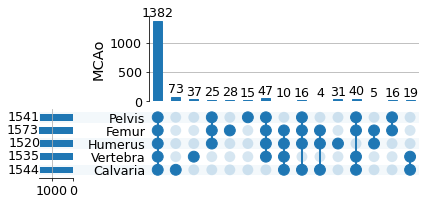

/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/4240785123.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  if comb in df_.index:
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/4240785123.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_.loc[comb, "value_counts_naive"] = i # vcount ## NOTE: not value count anymore, because that can lead to problems when combinations have the same value count


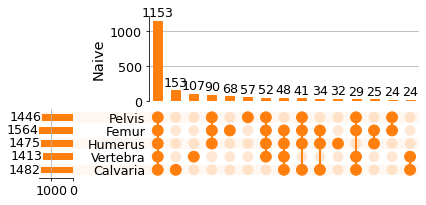

/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/4240785123.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  if comb in df_.index:
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/4240785123.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_.loc[comb, "value_counts_naive"] = i # vcount ## NOTE: not value count anymore, because that can lead to problems when combinations have the same value count


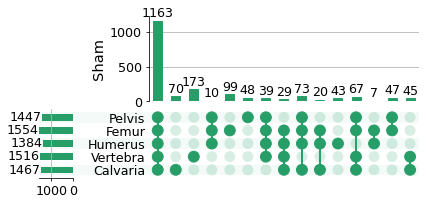

/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/4240785123.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  if comb in df_.index:
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/4240785123.py:38: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_.loc[comb, "value_counts_naive"] = i # vcount ## NOTE: not value count anymore, because that can lead to problems when combinations have the same value count


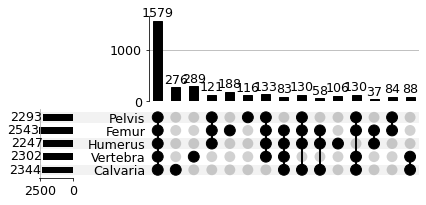

/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/4240785123.py:52: PerformanceWarning: indexing past lexsort depth may impact performance.
  if comb in df_.index:
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_16233/4240785123.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_.loc[comb, "value_counts_naive"] = i # vcount ## NOTE: not value count anymore, because that can lead to problems when combinations have the same value count


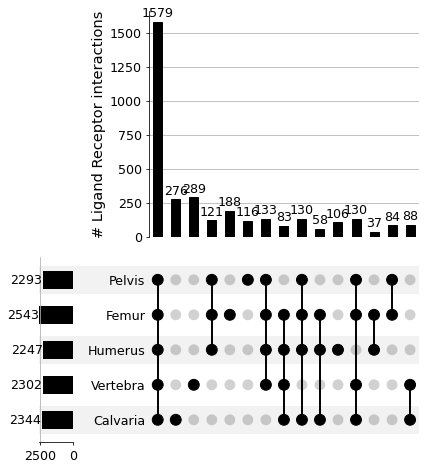

In [14]:
# Final plots

n_combs = 15
fig_width = 7
fig_height = 3

show_combs = dfs["Naive"].set_index(bones).index.value_counts().iloc[:n_combs].index.tolist()

cond_str = {"Naive":"Naive", "Sham":"Sham", "MCAO":"MCAo"}

# Plots per condition
for cond, color in cond_to_color.items():
    df_ = dfs_pseudo[cond].set_index(bones)#.index.value_counts()
    df_["value_counts_naive"] = 0
    for i, (comb, vcount) in enumerate(dfs["Naive"].set_index(bones).index.value_counts().items()):
        if comb in df_.index:
            df_.loc[comb, "value_counts_naive"] = i # vcount ## NOTE: not value count anymore, because that can lead to problems when combinations have the same value count
    df_ = df_.sort_values("value_counts_naive", ascending=True) #, ascending=False)
    df_ = df_.loc[df_.index.isin(show_combs)]
    
    ups = upsetplot.UpSet(df_, sort_by='input', sort_categories_by='input', show_counts=True, facecolor=color)
    tmp = df_pseudo.loc[df_pseudo[f"{cond}_pseudo"]].reset_index()
    for _, row in tmp.iterrows():
        ups.style_subsets(present=[b for b in bones if row[b]], absent=[b for b in bones if not row[b]],facecolor="gray") #,label="special")    
    axs = ups.plot()
    plt.gcf().set_size_inches(fig_width, fig_height)
    #axs['intersections'].set_ylabel(f"# Ligand Receptor\npairs ({cond_str[cond]})")
    axs['intersections'].set_ylabel(cond_str[cond])
    plt.gcf().savefig(f"../figures/LR_upset_seed{SEED}_{cond}.png", bbox_inches = "tight", transparent=False)
    plt.show()

    
# Plot for baseline    
df_ = df.copy()
df_["value_counts_naive"] = 0
for i, (comb, vcount) in enumerate(dfs["Naive"].set_index(bones).index.value_counts().items()):
    if comb in df_.index:
        df_.loc[comb, "value_counts_naive"] = i # vcount ## NOTE: not value count anymore, because that can lead to problems when combinations have the same value count
df_ = df_.sort_values("value_counts_naive", ascending=True) #, ascending=False)
df_ = df_.loc[df_.index.isin(show_combs)]
axs = upsetplot.UpSet(df_, sort_by='input', sort_categories_by='input', show_counts=True, facecolor="black").plot()
plt.gcf().set_size_inches(fig_width, fig_height)
axs['intersections'].set_ylabel(" ")
plt.gcf().savefig(
    f"../figures/LR_upset_seed{SEED}_pooled.png", bbox_inches="tight", transparent=True)
plt.show()
    
# Plot just for y axis label :'-(
df_ = df.copy()
df_["value_counts_naive"] = 0
for i, (comb, vcount) in enumerate(dfs["Naive"].set_index(bones).index.value_counts().items()):
    if comb in df_.index:
        df_.loc[comb, "value_counts_naive"] = i # vcount ## NOTE: not value count anymore, because that can lead to problems when combinations have the same value count
df_ = df_.sort_values("value_counts_naive", ascending=True) #, ascending=False)
df_ = df_.loc[df_.index.isin(show_combs)]
axs = upsetplot.UpSet(df_, sort_by='input', sort_categories_by='input', show_counts=True, facecolor="black").plot()
axs['intersections'].set_ylabel("# Ligand Receptor interactions")
plt.gcf().set_size_inches(fig_width, 8)
plt.gcf().savefig(f"../figures/LR_upset_seed{SEED}_pooled_y_axis_label.png", bbox_inches = "tight", transparent=True)
plt.show()

# Tables with gene lists of upset groups

Outputs are saved in `f"{RESULTS_DIR}/LR_pairs/230305_upset_LRs`

In [15]:
def write_LR_tables(adata, ct_key="level1", cond="Naive", seed=0):
    """
    """
    
    bones = ["Calvaria","Vertebra","Humerus","Femur","Pelvis"]
    
    #n_combs = 15
    
    
    if ct_key == "level1":
        ct_selections_key = "level1"
    elif ct_key == "level2":
        ct_selections_key = "level2_min10"
    
    
    df, _ = unique_interactions_df(
        cond,ct_selections[ct_selections_key],ct_selections_key=ct_selections_key,any_bone=False,seed=seed,
        max_pval=10**(-10),min_pval_diff=0.95,results_dir=RESULTS_DIR
    )
    
    # get occurence (nr of cell type pairs) for each interaction and combination
    cols = ["id_cp_interaction", "Calvaria", "Vertebra", "Humerus", "Femur", "Pelvis"]
    unique_combs = df.reset_index().groupby(cols).size()
    df_tmp = df.reset_index().set_index(cols)
    df_tmp["occurence"] = unique_combs
    df_tmp = df_tmp.reset_index()
    df['occurence'] = df_tmp['occurence'].values
    
    # reformatting
    df = df[bones + ["interacting_pair","gene_a","gene_b","occurence"]].reset_index().set_index(bones)
    df = df.rename(columns={"interacting_pair":"LR_pair","gene_a":"L_gene","gene_b":"R_gene"})
    df["L_celltype"] = df["level_1"].apply(lambda cts: cts.split("|")[0])
    df["R_celltype"] = df["level_1"].apply(lambda cts: cts.split("|")[1])
    #df["LR_interaction"] = df["LR_interaction"] + " - " + df["level_1"]
    df_min_occ5 = df.loc[df["occurence"] >= 5]
    df_min_occ1 = df[["LR_pair","L_gene","R_gene","L_celltype","R_celltype"]]
    df_min_occ5 = df_min_occ5[["LR_pair", "L_gene","R_gene", "L_celltype", "R_celltype"]]
    
    for df, occ_str in zip([df_min_occ1, df_min_occ5],["","_min_occurence_5"]):
        columns = []
        for idx in df.index.value_counts().index:
            df_ = df.loc[idx]
            for col in ["LR_pair","L_gene","R_gene","L_celltype","R_celltype"]:
                columns.append(list(idx) + df_[col].tolist())
        
        pad_len = max([len(col) for col in columns])
        for col in columns:
            col += [''] * (pad_len - len(col))
            
        df_ = pd.DataFrame(
            columns = bones + [''] * (pad_len - len(bones)) ,
            index = [col for i in range(len(df.index.unique())) for col in [
                f"comb{i} LR_pair", f"comb{i} L_gene", f"comb{i} R_gene", f"comb{i} L_celltype", f"comb{i} R_celltype"]
            ],
            data = columns,
        ).T
        
        columns = {}
        #col_idxs = [i for i in range(len(df_.columns)) if (i%4 == 0) or ((i-1)%4 == 0)]
        #for col in df_.iloc[:,col_idxs].columns:
        for col in df_.iloc[:,::5].columns:
            comb = col.split(" ")[0]
            unique_genes = df_.iloc[5:][f"{comb} L_gene"].unique().tolist() + df_.iloc[5:][f"{comb} R_gene"].unique().tolist()
            unique_genes = [g for g in unique_genes if str(g) != 'nan']
            columns[col] = df_.iloc[:5][col].tolist() + unique_genes
            
        pad_len = max([len(col) for col in columns.values()])
        for key in columns:
            columns[key] += [''] * (pad_len - len(columns[key]))
            
        df_2 = pd.DataFrame(
            index = bones + [''] * (pad_len - len(bones)) ,
            data = columns,
        )
        
        Path(RESULTS_DIR, "LR_pairs", f"230305_upset_LRs_seed{seed}").mkdir(parents=True, exist_ok=True)
        df_.to_excel(Path(RESULTS_DIR, "LR_pairs", f"230305_upset_LRs_seed{seed}", f"unique_interactions{occ_str}_{ct_key}_{cond}.xlsx"))
        df_2.to_excel(Path(RESULTS_DIR, "LR_pairs", f"230305_upset_LRs_seed{seed}", f"unique_genes{occ_str}_{ct_key}_{cond}.xlsx"))
    


In [16]:
for cond in ["Naive","Sham","MCAO"]:    
    write_LR_tables(adata, ct_key="level1", cond=cond, seed=SEED)
    #write_LR_tables(adata, ct_key="level2", cond=cond, seed=SEED)

/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_30737/2761996680.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = df.loc[idx]
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_30737/2761996680.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = df.loc[idx]
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_30737/2761996680.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = df.loc[idx]
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_30737/2761996680.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = df.loc[idx]
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_30737/2761996680.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = df.loc[idx]
/var/folders/_y/7znw3r4d1zd6f4qzlxgnf461brzyqh/T/ipykernel_30737/2761996680.py:42: PerformanceWarning: indexing past lexsort 

# GO terms for gene lists

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 20#13
MEDIUM_SIZE = 22#15
BIGGER_SIZE = 24#17
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [6]:
import sys
sys.path.insert(0,'.../skull_immune/transcriptomics')
# sys.path.insert(0, "../../../")

In [7]:
from gprofiler_plotting import gprofiler_enrich


In [20]:
from gprofiler_plotting import gprofiler_enrich
import scipy.cluster.hierarchy as sch
from matplotlib import colors

def GO_plot(genes,plot_heatmap=True,save_en=False,save_hm=False,show_plots=False,return_dfs=False,max_n_genes=150,save_gp_df=False):
    """
    """
    #if not os.path.exists(save_hm): # DELETE THIS IF STATEMENT!!!! (just used since gprofiler is down)
    rcParams['figure.figsize']= (4.8,4.8)
    enrich_df = gprofiler_enrich(genes,
                                 save=save_en,
                                 plot=show_plots)
    if save_gp_df:
        enrich_df.sort_values('p_value').to_csv(save_gp_df)
    
    rcParams['figure.figsize']= (4.5+min(max_n_genes,len(genes)),6.5)
    
    if plot_heatmap:
        enrich_df = enrich_df.sort_values('p_value')[:20]
        hm_df = plot_GO_heatmap(genes,enrich_df,show=show_plots,save=save_hm,max_n_genes=max_n_genes)
    
        if return_dfs:
            return enrich_df, hm_df
    if return_dfs:
        return enrich_df 
    
def plot_GO_heatmap(genes,df,show=False,save=False,reorder_heatmap=True,max_n_genes=150):
    """
    max_n_genes: only show the top max_n_genes sorted based on number of GO terms
    """
    
    # this shouldnt be here, but we have rcparams adjustments in the other GO plot, so we need to reset them
    SMALL_SIZE = 20  # 13
    MEDIUM_SIZE = 22  # 15
    BIGGER_SIZE = 24  # 17
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    
    df_tmp = pd.DataFrame(index=df["name"],
                 columns=genes,
                 data={g:df["intersections"].apply(lambda gs: g in gs).astype(int).tolist() for g in genes}
                )
    if (len(df_tmp.columns) > 1) and max_n_genes:
        cols = df_tmp.sum().sort_values(ascending=False)[:min(len(df_tmp.columns),max_n_genes)].index.tolist()
        df_tmp = df_tmp[cols]
    
    if reorder_heatmap and (len(df_tmp.columns) > 1):
        # Reorder by linkage clustering
        pairwise_distances = sch.distance.pdist(df_tmp.values.T)
        linkage = sch.linkage(pairwise_distances, method="complete")
        cluster_distance_threshold = pairwise_distances.max() / 2
        idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, criterion="distance")
        idx = np.argsort(idx_to_cluster_array)
        df_tmp = df_tmp[df_tmp.columns[idx]]
        # Invert gene order if genes with fewer terms are on the left side of the heatmap
        mean_1st_half = df_tmp[df_tmp.columns[:len(df_tmp.columns)//2]].values.mean()
        mean_2nd_half = df_tmp[df_tmp.columns[len(df_tmp.columns)//2:]].values.mean()
        if mean_1st_half < mean_2nd_half:
            df_tmp = df_tmp[df_tmp.columns[::-1]]
    cmap = plt.get_cmap('Greens')
    new_cmap = truncate_colormap(cmap, 0.15, 0.8)
    hm = sns.heatmap(df_tmp,cmap=new_cmap, square=True, linewidths=.1, xticklabels=1, yticklabels=1, cbar=False)
    if save:
        fig = hm.get_figure()
        fig.savefig(save,bbox_inches = "tight")
    if show:
        plt.show()
    else:
        plt.close()
    return df_tmp 

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [21]:
def GO_plots_for_upset_gene_lists(
        cond="Naive",ct_key="level1",min_genes=4,
        show=True,save=False,save_gp_df=False,occ_str="", # occ_str = "_min_occurence_5" or ""
        seed=0,
):
    """
    """
    df = pd.read_excel(
        Path(RESULTS_DIR, "LR_pairs", f"230305_upset_LRs_seed{seed}", f"unique_genes{occ_str}_{ct_key}_{cond}.xlsx"),
        index_col=0 
    )
    
    bones = df.index[:5].tolist()
    
    for col in df.columns:
        
        up_in = "_".join([b for i,b in enumerate(bones) if bool(df[col].iloc[i])]) 
        
        comb = col.split(" ")[0]
        
        df_not_nan = ~df[col].isnull()
        gene_list = np.unique(df.loc[df_not_nan,col].iloc[5:]).tolist() # should already be unique
        
        if len(gene_list) < min_genes:
            continue
        
        fig_dir = Path(".","figures",f"LR_upset_seed{seed}_GO{occ_str}",f"{cond}_{ct_key}",f"{comb}_up_in_{up_in}")
        if save:
            fig_dir.mkdir(parents=True, exist_ok=True)
        
        if save_gp_df:
            base_dir = Path(RESULTS_DIR,"LR_pairs",f"230305_upset_LRs_seed{seed}",f"GO_tables{occ_str}",f"{cond}_{ct_key}")
            base_dir.mkdir(parents=True, exist_ok=True)
            save_df = Path(base_dir,f"{col.replace(' ','_')}.csv")
        else:
            save_df = False
        
        GO_plot(
            gene_list,plot_heatmap=True,
            save_en=Path(fig_dir, f"unique_genes_enrichment.png") if save else False,
            save_hm=Path(fig_dir, f"unique_genes_GO_gene_matrix.png") if save else False,
            show_plots=show,return_dfs=False,max_n_genes=200,save_gp_df=save_df
        )

##### Example run (with plots shown)

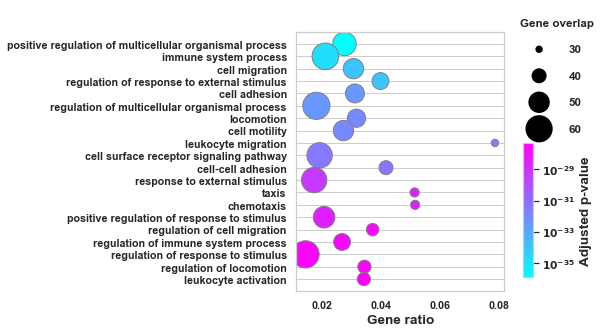

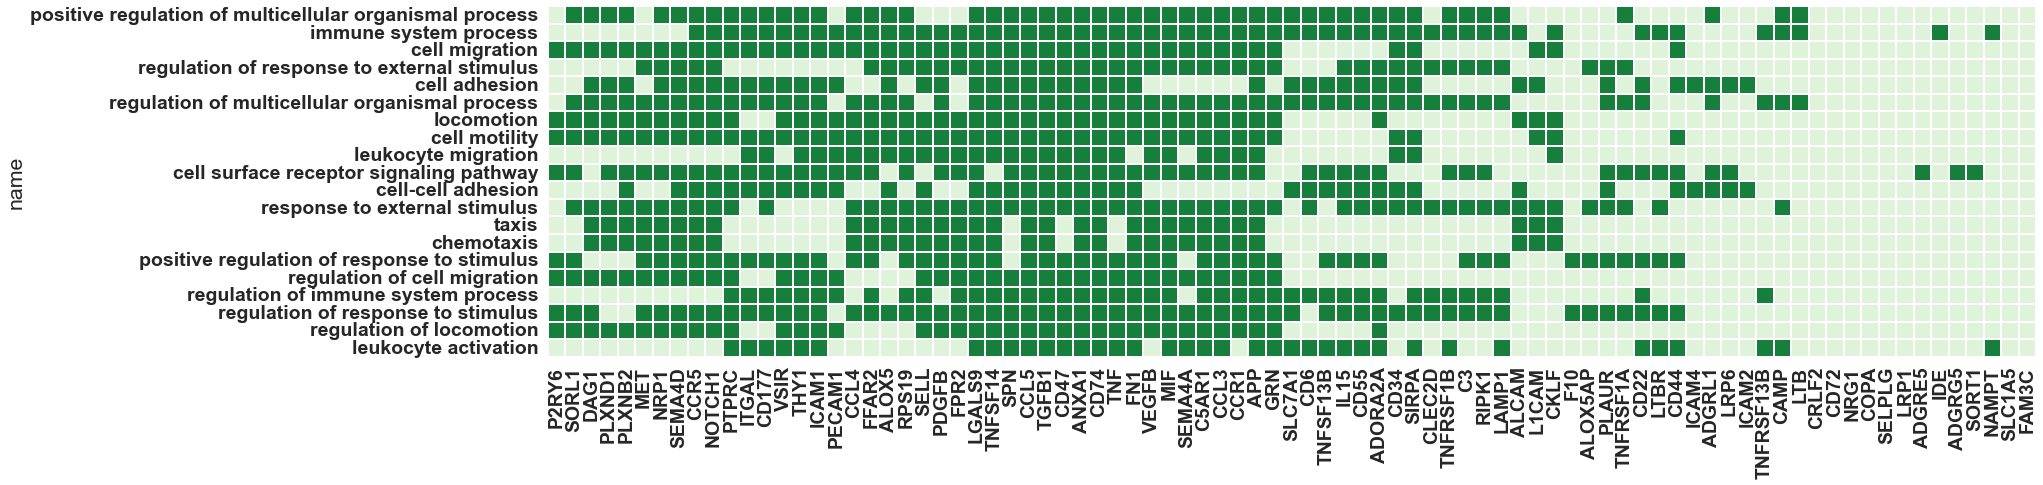

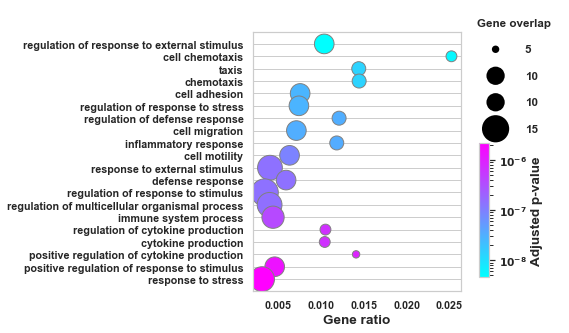

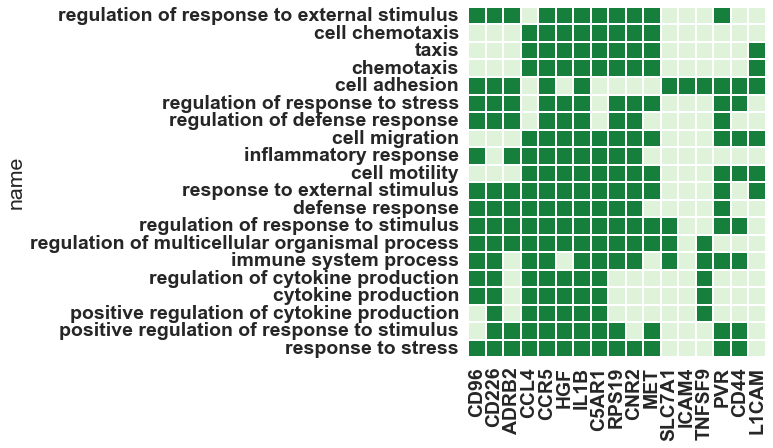

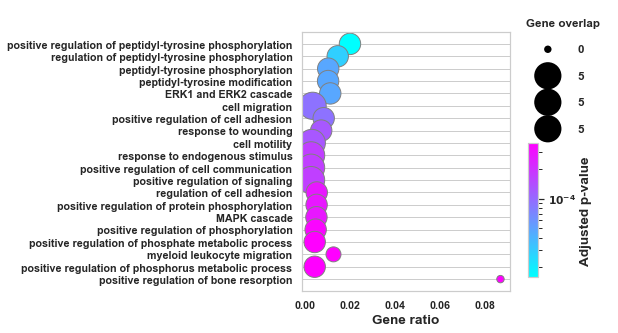

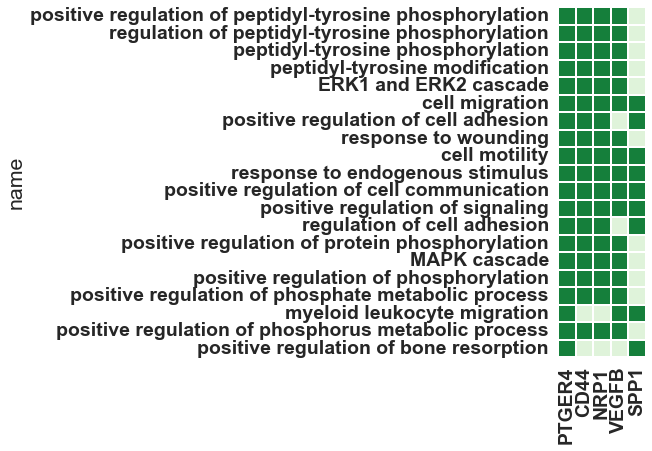

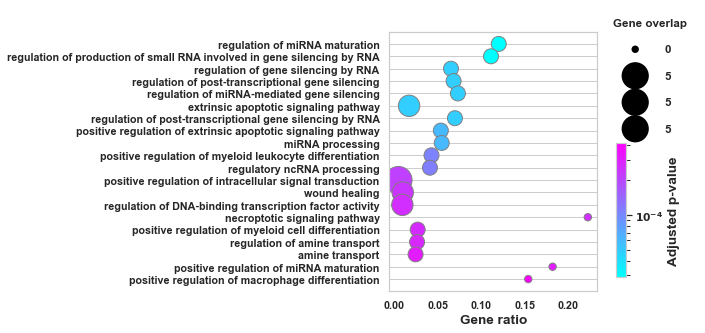

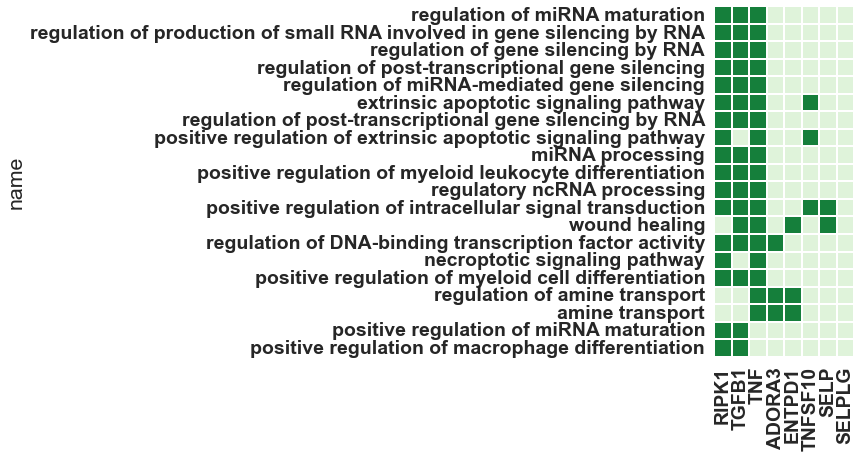

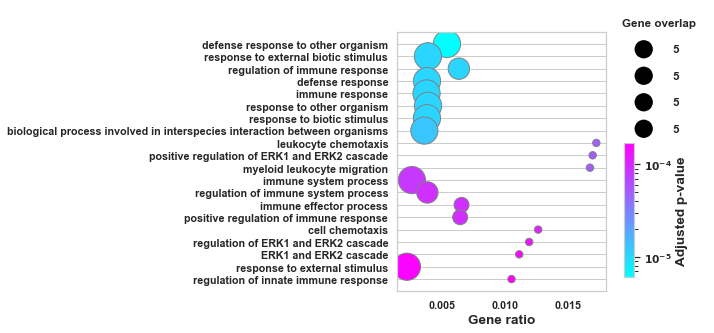

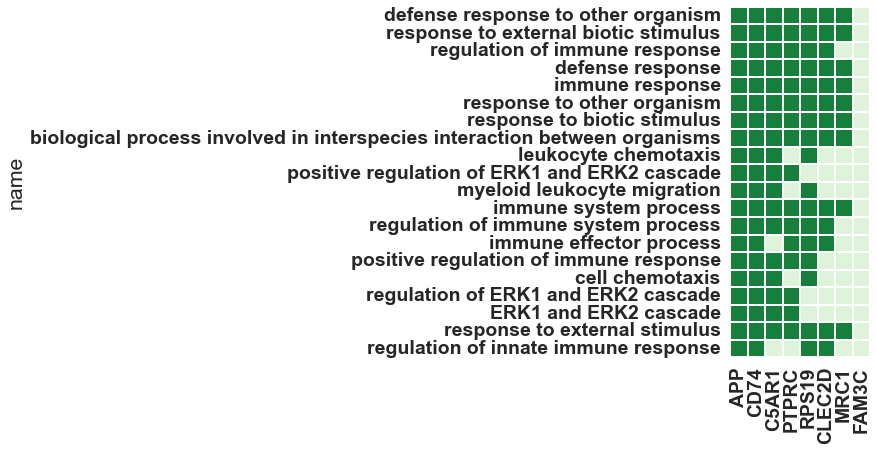

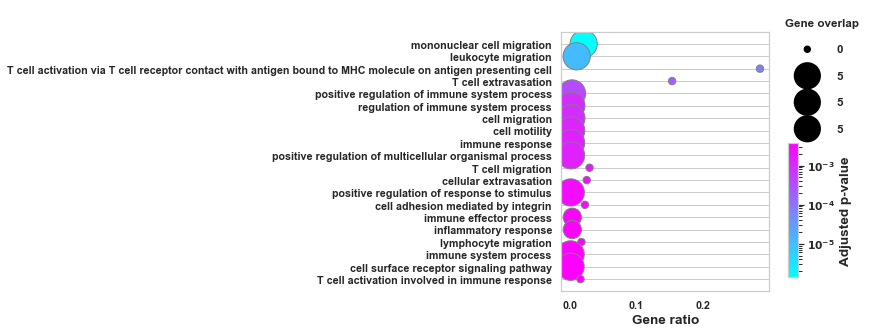

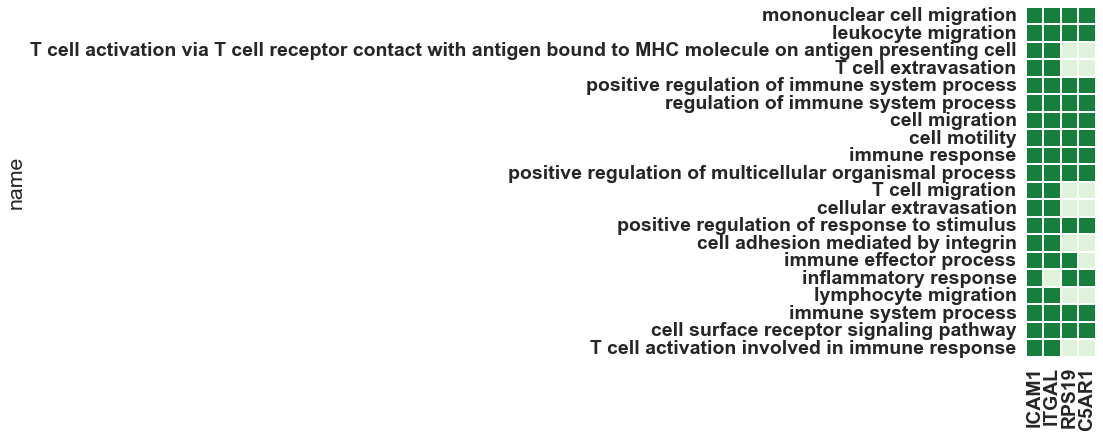

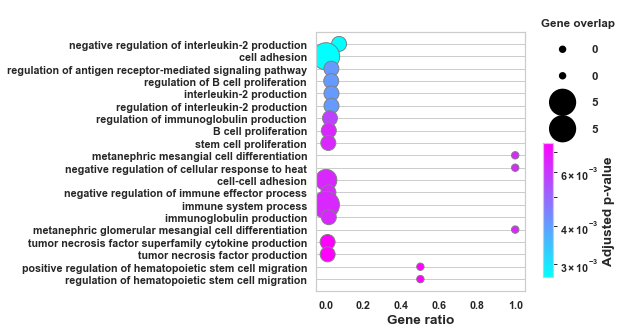

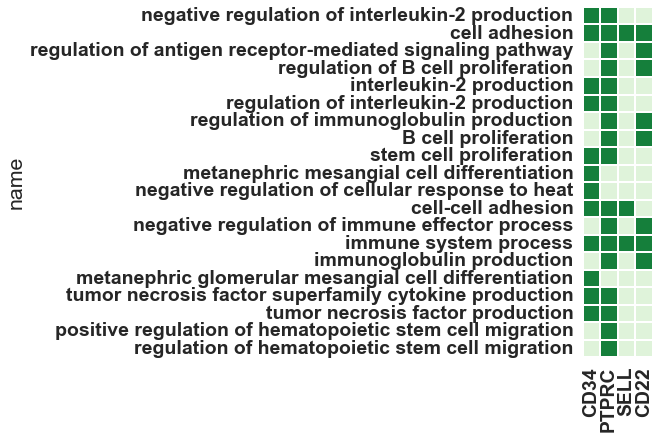

In [22]:
GO_plots_for_upset_gene_lists(
    cond="Naive",ct_key="level1",min_genes=4,show=True,save=True,save_gp_df=True,occ_str="_min_occurence_5",seed=SEED
)

##### All runs (plots only saved in `./figures/LR_upset_GO/`, not shown)

gprofiler tables saved in `Path(RESULTS_DIR,"LR_pairs","230305_upset_LRs","GO_tables")`


In [30]:
MIN_GENES = 4

for cond in ["Naive", "Sham", "MCAO"]:  # ["MCAO"]: #
    for ct_key in ["level1"]:#, "level2"]:
        print(f"### cond - {cond} | ct_key - {ct_key} ###")
        GO_plots_for_upset_gene_lists(
            cond=cond,ct_key=ct_key,min_genes=MIN_GENES,show=False,save=True,save_gp_df=True,occ_str=""
        )
        GO_plots_for_upset_gene_lists(
            cond=cond, ct_key=ct_key, min_genes=2, show=False, save=True, save_gp_df=True, occ_str="_min_occurence_5", seed=SEED
        )

### cond - Naive | ct_key - level1 ###
### cond - Sham | ct_key - level1 ###
### cond - MCAO | ct_key - level1 ###


### Save multiple gprofiler tables as one excel sheet

We only take the combinations of Calvaria unique, vertebra unique, femur unique (--> for each condition --> 9 excel sheets)

In [7]:
bones = ['Calvaria', 'Vertebra', 'Humerus', 'Femur', 'Pelvis']
combs_oi = {
    "Calvaria_unique" : [1,0,0,0,0],
    "Vertebra_unique" : [0,1,0,0,0],
    "Femur_unique"    : [0,0,0,1,0],
}

for ct_key in ["level1"]: #["level1","level2"]:
        
    dfs = {}
    
    for cond in ["Naive","Sham","MCAO"]:
    
        # Get gene list table to retrieve comb name info
        tmp = pd.read_excel(
            Path(
                RESULTS_DIR, "LR_pairs", f"230305_upset_LRs_seed{SEED}",
                f"unique_genes_{ct_key}_{cond}.xlsx"
        ),index_col=0)
        
        # Load gprofiler tables for each combination of interest
        for comb_name, comb in combs_oi.items():
            col = (tmp.loc[bones].T == comb).all(axis=1).idxmax()
            
            csv_file = Path(
                RESULTS_DIR, "LR_pairs", f"230305_upset_LRs_seed{SEED}", "GO_tables",
                f"{cond}_{ct_key}",
                f"{col.replace(' ','_')}.csv"
            )
            
            dfs[f"{cond} {comb_name}"] = pd.read_csv(csv_file,index_col=0)
        
    # Write to excel
    excel_file = Path(
        #RESULTS_DIR, "LR_pairs","230305_upset_LRs","GO_tables_excel",
        ".",
        f"LR_upset_seed{SEED}_GO_terms_{ct_key}.xlsx"
    )
    
    with pd.ExcelWriter(excel_file) as writer:
        for sheet,df in dfs.items():
            df.to_excel(writer, sheet_name=sheet)